In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imgw_api import get_hydro_metadata,get_meteo_metadata

In [8]:
meteo = pd.read_parquet("../static_data/filtered_meteo_opad_data.parquet.gzip")
hydro = pd.read_parquet("../static_data/filtered_hydro_data.parquet.gzip")

meteo_gdf = get_meteo_metadata(True)
hydro_gdf = get_hydro_metadata(True)

zlewnie = gpd.read_file('../static_data/zlewnie/zlewnie_2.gpkg')

In [9]:
zlewnia10 = zlewnie[zlewnie['objectid'] == 10]
hydro_in_zlewnia10 = gpd.sjoin(hydro_gdf, zlewnia10, predicate='within')
meteo_in_zlewnia10 = gpd.sjoin(meteo_gdf, zlewnia10, predicate='within')

In [12]:
hydro

,Station Code,Station Name,Name,Hydro Year,Hydro Month,Day,Water Level,Flow,Water Temp,Calendar Month,Calendar Year,Calendar Date
0,149180020,CHA£UPKI,Odra (1),2010,3,1,201.0,71.90,NaN,1,2010,2010-01-01
1,149180020,CHA£UPKI,Odra (1),2010,3,2,202.0,73.00,NaN,1,2010,2010-01-02
2,149180020,CHA£UPKI,Odra (1),2010,3,3,193.0,64.10,NaN,1,2010,2010-01-03
3,149180020,CHA£UPKI,Odra (1),2010,3,4,181.0,51.70,NaN,1,2010,2010-01-04
4,149180020,CHA£UPKI,Odra (1),2010,3,5,180.0,51.40,NaN,1,2010,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...
301685,149190250,JABŁONKA,Piekielnik (82224),2023,2,27,161.0,3.08,NaN,12,2022,2022-12-27
301686,149190250,JABŁONKA,Piekielnik (82224),2023,2,28,157.0,2.42,NaN,12,2022,2022-12-28
301687,149190250,JABŁONKA,Piekielnik (82224),2023,2,29,153.0,1.80,NaN,12,2022,2022-12-29
301688,149190250,JABŁONKA,Piekielnik (82224),2023,2,30,151.0,1.32,NaN,12,2022,2022-12-30


In [15]:
# Lista nazw stacji w zlewni 10
hydro_stations = hydro_in_zlewnia10['Station Code'].tolist()
meteo_stations = meteo_in_zlewnia10['Station Code'].tolist()

# Filtrowanie danych tylko do stacji w zlewni 10
hydro10 = hydro[hydro['Station Code'].isin(hydro_stations)]
meteo10 = meteo[meteo['Station Code'].isin(meteo_stations)]

<Axes: xlabel='Calendar Date'>

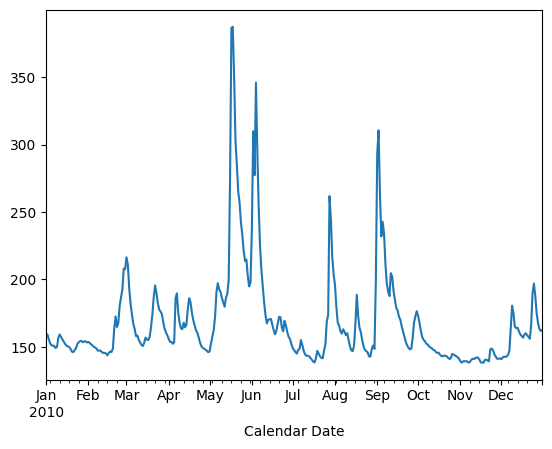

In [119]:
water_level_zlewnia[water_level_zlewnia.index < '2011-01-01'].plot()

In [95]:
# Średnie wartości w zlewni
water_level_zlewnia = (
    hydro10.groupby('Calendar Date')['Water Level']
    .mean()
    .rename('mean_water_level')
)

precip_zlewnia = (
    meteo10.groupby('Calendar Date')['Daily Precip Sum']
    .mean()
    .rename('total_precipitation')
)

flow_zlewnia = (
    hydro10.groupby('Calendar Date')['Flow']
    .mean()
    .rename('mean_flow')
)

# Połączenie wszystkiego
df = pd.concat([water_level_zlewnia, precip_zlewnia, flow_zlewnia], axis=1).dropna()


In [96]:
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['dayofyear'] = df.index.dayofyear

In [112]:
df['target'] = df['mean_water_level'].shift(-1)  # 7 dni do przodu
df = df.dropna()

C:\Users\Tymek\AppData\Local\Temp\ipykernel_31828\2248451368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['mean_water_level'].shift(-1)  # 7 dni do przodu


In [113]:
df

,mean_water_level,total_precipitation,mean_flow,dayofweek,month,dayofyear,target
Calendar Date,,,,,,,
2010-01-01,159.551181,0.808824,18.544127,4,1,1,159.165354
2010-01-02,159.165354,4.768056,20.198571,5,1,2,155.622047
2010-01-03,155.622047,2.284722,19.048254,6,1,3,152.531746
2010-01-04,152.531746,0.202778,16.757520,0,1,4,151.238095
2010-01-05,151.238095,0.516667,14.820240,1,1,5,151.040000
...,...,...,...,...,...,...,...
2022-12-13,141.195652,0.202174,9.809500,1,12,347,140.688406
2022-12-14,140.688406,2.945652,9.118545,2,12,348,141.369565
2022-12-15,141.369565,2.795652,9.281652,3,12,349,140.724638


In [114]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['mean_water_level', 'target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 3.731225847250244
R²: 0.8823923372167238


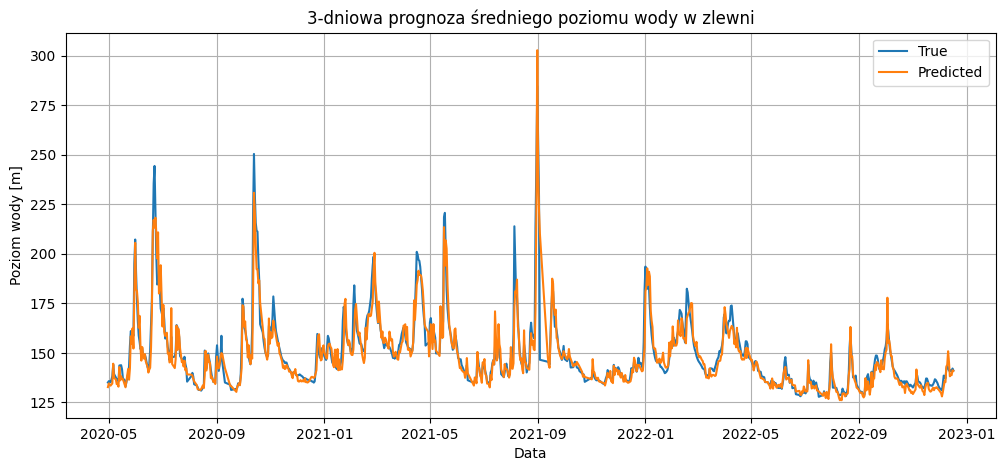

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('3-dniowa prognoza średniego poziomu wody w zlewni')
plt.xlabel('Data')
plt.ylabel('Poziom wody [m]')
plt.grid()
plt.show()